In [1]:
import os

import clrs
import jax
import numpy as np

encode_hints = True
decode_hints = True

rng = np.random.RandomState(42)
rng_key = jax.random.PRNGKey(rng.randint(2**32, dtype=np.int64))

processor_factory = clrs.get_processor_factory(
    'triplet_gmpnn',
    use_ln=True,
    nb_triplet_fts=8,
    nb_heads=1,
    )
model_params = dict(
    processor_factory=processor_factory,
    hidden_dim=128,
    encode_hints=encode_hints,
    decode_hints=decode_hints,
    encoder_init='xavier_on_scalars',
    use_lstm=False,
    learning_rate=0.001,
    grad_clip_max_norm=1.0,
    checkpoint_path='checkpoints/CLRS30',
    freeze_processor=False,
    dropout_prob=0.0,
    hint_teacher_forcing=0.0,
    hint_repred_mode='soft',
    nb_msg_passing_steps=1,
    )


2025-03-08 23:48:25.245758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741477705.257935  117177 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741477705.261233  117177 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from interp.dataset import HDF5Dataset

# --- Saving Data ---
def save_to_hdf5(data, filename, nested=True):
    """
    Save data to HDF5 file format.
    
    Args:
        data: List of dictionaries (or dictionary of dictionaries if nested=True)
        filename: Path to save the HDF5 file
        nested: If True, treats data as list of dictionary of dictionaries.
                If False, treats data as list of dictionaries.
    """
    with h5py.File(filename, 'w') as f:
        for i, datapoint in enumerate(data):
            group = f.create_group(f'datapoint_{i}')  # Create a group for each datapoint
            
            if nested:
                # Handle nested dictionary structure
                for algo_key, algo_dict in datapoint.items():
                    # Create a subgroup for each algorithm
                    algo_group = group.create_group(algo_key)
                    # Store each array in the algorithm's dictionary
                    for key, array in algo_dict.items():
                        algo_group.create_dataset(key, data=array, compression="gzip")
            else:
                # Handle flat dictionary structure
                for key, array in datapoint.items():
                    # Store each array as a dataset within the group
                    group.create_dataset(key, data=array, compression="gzip")


# Creating joint training Data

Only run these cells if creating training data where multiple algorithms are being trained on the interpretation models at once. Otherwise skip to the next section for single algorithm data generation

In [3]:
# For JOINT Algorithm sampling data creation
# each datapoint is a dictionary of dictionaries. The outer dictionary has keys as the algorithm names and the inner dictionary has keys as the algorithm names and the values are the dataloader for that algorithm.
from tqdm import tqdm
from copy import deepcopy
# Set up multiple lengths and samples per length
LENGTHS = [16]
# LENGTHS = [4, 7, 11, 13, 16]
# LENGTHS = [20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
SAMPLES_PER_LENGTH = 500
# whether to include self connections in the graph
INCLUDE_SELF_CONNECTIONS = False

algorithms = ["bellman_ford", "bfs"]

data = {}
for length_idx, length in enumerate(LENGTHS):
    new_rng_key, rng_key = jax.random.split(rng_key)    

    # Create data for all samples of this length for each algorithm
    for algo in algorithms:
        # Create sampler for this length
        sampler, spec = clrs.build_sampler(
            algo,
            seed=rng.randint(2**32, dtype=np.int64),
            num_samples=SAMPLES_PER_LENGTH,
            length=length,
        )

        # Get dummy trajectory and initialize model
        dummy_traj = [sampler.next()]
        model = clrs.models.BaselineModel(
            spec=[spec],
            dummy_trajectory=dummy_traj,
            get_inter=True,
            **model_params
        )

        all_features = [f.features for f in dummy_traj]
        model.init(all_features, 42)

        # Get predictions for this length
        feedback = sampler.next()

        model.restore_model(f'best_{algo}.pkl', only_load_processor=False)
        preds, _, hist = model.predict(new_rng_key, feedback.features)
        for item in tqdm(range(SAMPLES_PER_LENGTH)):
            
            feedback_hint_names = [f.name for f in feedback.features.hints]
            feedback_input_names = [f.name for f in feedback.features.inputs]
            feedback_output_names = [f.name for f in feedback.outputs]

            if INCLUDE_SELF_CONNECTIONS:
                graph_adj = feedback.features.inputs[feedback_input_names.index("adj")].data[item] # (D, D)
                # make sure diagonal is all 1s
                graph_adj[np.arange(graph_adj.shape[0]), np.arange(graph_adj.shape[0])] = 1
                edge_weights = feedback.features.inputs[feedback_input_names.index("A")].data[item] # (D, D)
                # make sure diagonal is all 1s
                edge_weights[np.arange(edge_weights.shape[0]), np.arange(edge_weights.shape[0])] = 1
            else:
                graph_adj = feedback.features.inputs[feedback_input_names.index("adj")].data[item] # (D, D)
                edge_weights = feedback.features.inputs[feedback_input_names.index("A")].data[item] # (D, D)
                graph_adj[np.arange(graph_adj.shape[0]), np.arange(graph_adj.shape[0])] = 0
                edge_weights[np.arange(edge_weights.shape[0]), np.arange(edge_weights.shape[0])] = 0
            
            start_node = feedback.features.inputs[feedback_input_names.index("s")].data[item] # (D)
            
            gt_pi = feedback.outputs[feedback_output_names.index("pi")].data[item] # (D)

            # for upd_pi, sometimes we need to get rid of trailing zero entries (for algorithms that don't have fixed numbre of time steps)
            # detect whether there are trailing zero vectors in the last time dimensions of upd_pi and find the cutoff index
            # then take the first n entries of upd_pi and upd_d where n is the cutoff index
            
            raw_upd_pi = feedback.features.hints[feedback_hint_names.index("upd_pi")].data[:,item,:] # (T, D)
            raw_upd_d = feedback.features.hints[feedback_hint_names.index("upd_d")].data[:,item,:] # (T, D)
            # Find the cutoff index by detecting trailing zero vectors
            # A vector is considered zero if all its elements are zero
            is_zero_vector = np.all(raw_upd_pi == np.zeros(raw_upd_pi.shape[1]), axis=1)
            
            # Find the last non-zero vector index
            non_zero_indices = np.where(~is_zero_vector)[0]
            if len(non_zero_indices) > 0:
                cutoff_idx = non_zero_indices[-1] + 1  # +1 to include the last non-zero vector
            else:
                cutoff_idx = raw_upd_pi.shape[0]  # Use all if no zero vectors found
            
            # if cutoff_idx is less than 2, we should make upd_pi and upd_d have length 2, but pad upd_pi with arange(length) and upd_d with zeros
            if cutoff_idx < 2:
                upd_pi = raw_upd_pi[:2]
                upd_d = raw_upd_d[:2]
                for i in range(2-cutoff_idx):
                    upd_pi[-i-1] = np.arange(raw_upd_pi.shape[1])
                    upd_d[-i-1] = np.zeros(raw_upd_d.shape[1], dtype=np.float32)
                cutoff_idx = 2
            else:
                # Take only the first n entries where n is the cutoff index
                upd_pi = raw_upd_pi[:cutoff_idx]
                upd_d = raw_upd_d[:cutoff_idx]

            hidden_states = np.stack([hist[i].hiddens[item] for i in range(cutoff_idx)]).transpose((0,2,1)) # (T, H, D)
            
            datapoint = {
                'hidden_states': deepcopy(hidden_states),
                'graph_adj': deepcopy(graph_adj),
                'edge_weights': deepcopy(edge_weights), 
                'upd_pi': deepcopy(upd_pi),
                'upd_d': deepcopy(upd_d),
                'gt_pi': deepcopy(gt_pi),
                'start_node': deepcopy(start_node),
            }

            if item + length_idx*SAMPLES_PER_LENGTH not in data:
                data[item + length_idx*SAMPLES_PER_LENGTH] = {}  
            
            data[item + length_idx*SAMPLES_PER_LENGTH][algo] = deepcopy(datapoint)


100%|██████████| 500/500 [00:01<00:00, 460.75it/s]


## Visualise Graphs

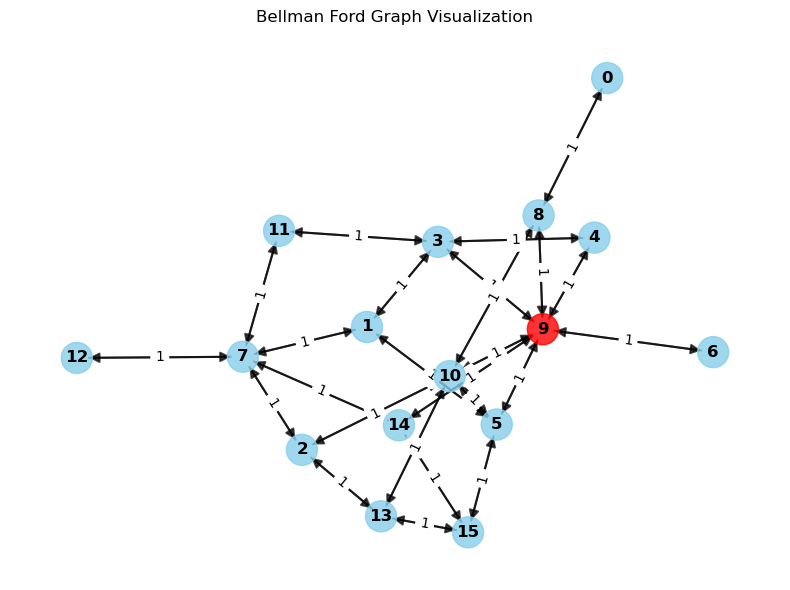

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
 [ 0.  1.  2.  9.  9.  9.  9.  7.  9.  9.  9. 11. 12. 13.  9. 15.]
 [ 8.  3. 10.  3.  4.  5.  6. 14.  8.  9. 10.  3. 12. 10. 14.  5.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.  7. 13. 14. 15.]]


In [4]:
from interp.visualisation import visualize_graph
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(data)-1)
datapoint = data[random_idx]
# Example usage
fig, ax = visualize_graph(datapoint['bfs'], title="Bellman Ford Graph Visualization")
plt.show()
print(datapoint['bfs']['upd_d'])
print(datapoint['bfs']['upd_pi'])


In [ ]:
# from sklearn.model_selection import train_test_split
# train_data, val_data = train_test_split(data, train_size=0.99, random_state=42)
# save_to_hdf5(train_data, os.path.join("data", "_".join(algorithms), "interp_data_16_eval.h5"), nested= True)

In [5]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.9

train_data, val_data = train_test_split(data, train_size=TRAIN_RATIO, random_state=42)

save_root = os.path.join("data", "_".join(algorithms))
save_name = "interp_data_all"

save_to_hdf5(train_data, os.path.join(save_root, save_name + ".h5"), nested=True)
save_to_hdf5(val_data, os.path.join(save_root, save_name + "_eval.h5"), nested=True)

In [14]:
from interp.dataset import HDF5Dataset
from interp.dataset import custom_collate, nested_custom_collate
import torch
from torch.utils.data import DataLoader
import os


algorithms = ["bellman_ford", "bfs"]
save_root = os.path.join("data", "_".join(algorithms))
save_name = "interp_data_all"

# Load the saved datasets
train_dataset = HDF5Dataset(os.path.join(save_root, save_name + ".h5"), nested=True)
val_dataset = HDF5Dataset(os.path.join(save_root, save_name + "_eval.h5"), nested=True)

# Create DataLoaders
batch_size = 4
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=nested_custom_collate
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=nested_custom_collate
)

# Print some information about the datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check the first batch
sample_batch = next(iter(train_loader))
print("Sample batch keys:", sample_batch.keys())

for key in sample_batch.keys():
    algo_input = sample_batch[key]
    for field in algo_input.keys():
        print("algo", key, field, algo_input[field].shape)

Training dataset size: 4500
Validation dataset size: 500
Sample batch keys: dict_keys(['bellman_ford', 'bfs'])
algo bellman_ford batch torch.Size([26])
algo bellman_ford num_graphs torch.Size([])
algo bellman_ford num_nodes_per_graph torch.Size([4])
algo bellman_ford all_cumsum torch.Size([5])
algo bellman_ford edge_weights torch.Size([26, 26])
algo bellman_ford graph_adj torch.Size([26, 26])
algo bellman_ford gt_pi torch.Size([26])
algo bellman_ford hidden_states torch.Size([26, 128, 26])
algo bellman_ford timesteps_per_graph torch.Size([4])
algo bellman_ford all_cumsum_timesteps torch.Size([5])
algo bellman_ford start_node torch.Size([26])
algo bellman_ford upd_d torch.Size([26, 26])
algo bellman_ford upd_pi torch.Size([26, 26])
algo bfs batch torch.Size([26])
algo bfs num_graphs torch.Size([])
algo bfs num_nodes_per_graph torch.Size([4])
algo bfs all_cumsum torch.Size([5])
algo bfs edge_weights torch.Size([26, 26])
algo bfs graph_adj torch.Size([26, 26])
algo bfs gt_pi torch.Size([2

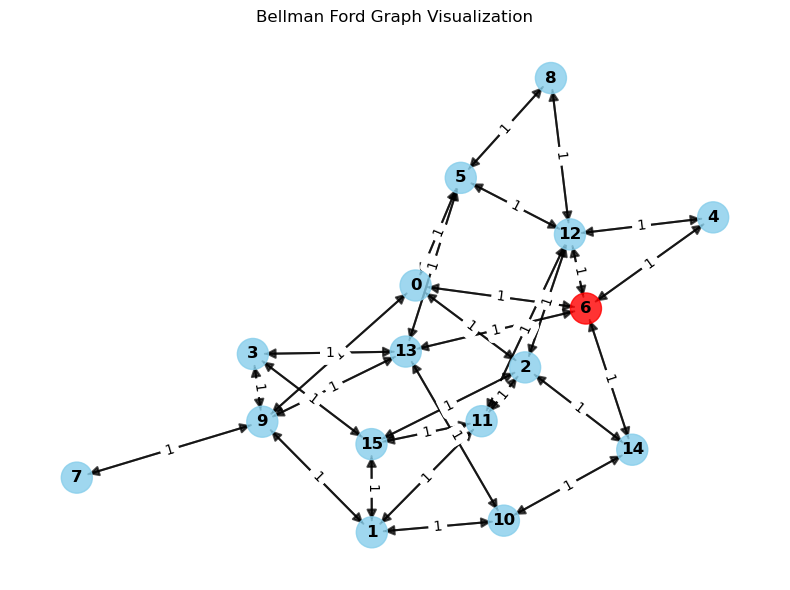

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
 [ 6.  1.  2.  3.  6.  5.  6.  7.  8.  9. 10. 11.  6.  6.  6. 15.]
 [ 0.  1.  0. 13.  4.  0.  6.  7. 12.  0. 13. 12. 12. 13. 14. 15.]
 [ 0.  9.  2.  3.  4.  5.  6.  9.  8.  9. 10. 11. 12. 13. 14.  2.]]


In [23]:
from interp.visualisation import visualize_graph
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(data)-1)
datapoint = data[random_idx]
# Example usage
fig, ax = visualize_graph(datapoint['bfs'], title="Bellman Ford Graph Visualization")
plt.show()
print(datapoint['bfs']['upd_d'])
print(datapoint['bfs']['upd_pi'])

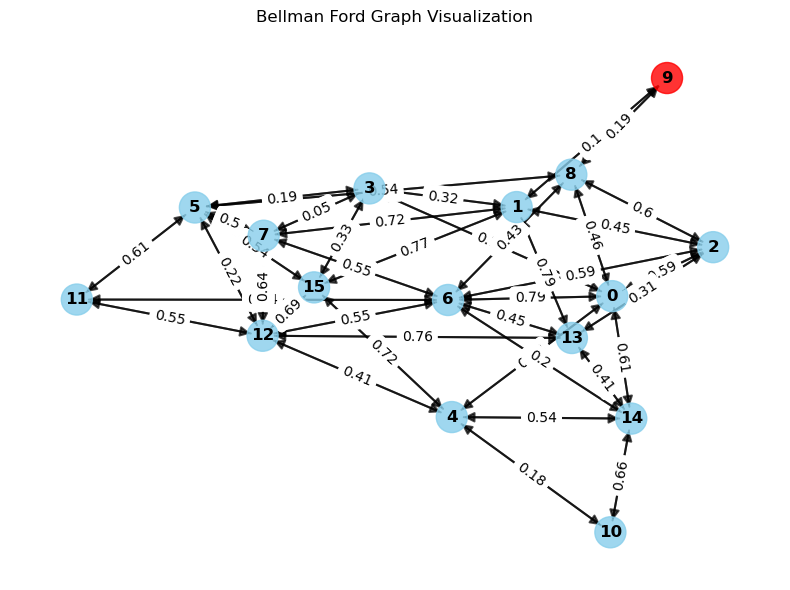

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.10485802 0.         0.         0.         0.
  0.         0.         0.191551   0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6475205  0.         0.5498816  0.42925086 0.         0.73535729
  0.62021257 0.8237343  0.         0.         0.         0.
  0.         0.89459807 0.         0.87515821]
 [0.59964135 0.         0.         0.         0.82635422 0.61488127
  0.         0.48399993 0.         0.         0.         0.96292809
  0.95852559 0.86395019 0.81916592 0.7582183 ]
 [0.         0.         0.         0.         0.77847507 0.
  0.         0.         0.         0.         1.0103086  0.
  0.83804957 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.96242945 0.
  0.         0.      

In [25]:
fig, ax = visualize_graph(datapoint['bellman_ford'], title="Bellman Ford Graph Visualization")
plt.show()
print(datapoint['bellman_ford']['upd_d'])
print(datapoint['bellman_ford']['upd_pi'])

In [19]:
(sample_batch['bellman_ford']['graph_adj'] == sample_batch['bfs']['graph_adj'])

tensor([[ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
  

# Creating single algorithm Data

Use this section code for single algorithm data generation

In [3]:
from tqdm import tqdm
# Set up multiple lengths and samples per length
LENGTHS = [16]
# LENGTHS = [4, 7, 11, 13, 16]
# LENGTHS = [20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
SAMPLES_PER_LENGTH = 5000
INCLUDE_SELF_CONNECTIONS = False

alg = "bfs"

data = []
for length in LENGTHS:
    # Create sampler for this length
    sampler, spec = clrs.build_sampler(
        alg,
        seed=rng.randint(2**32, dtype=np.int64),
        num_samples=SAMPLES_PER_LENGTH,
        length=length,
    )

    # Get dummy trajectory and initialize model
    dummy_traj = [sampler.next()]
    model = clrs.models.BaselineModel(
        spec=[spec],
        dummy_trajectory=dummy_traj,
        get_inter=True,
        **model_params
    )

    all_features = [f.features for f in dummy_traj]
    model.init(all_features, 42)
    model.restore_model(f'best_{alg}.pkl', only_load_processor=False)

    # Get predictions for this length
    feedback = sampler.next()
    new_rng_key, rng_key = jax.random.split(rng_key)
    preds, _, hist = model.predict(new_rng_key, feedback.features)

    # Create data for all samples of this length
    for item in tqdm(range(SAMPLES_PER_LENGTH)):
        feedback_hint_names = [f.name for f in feedback.features.hints]
        feedback_input_names = [f.name for f in feedback.features.inputs]
        feedback_output_names = [f.name for f in feedback.outputs]

        if INCLUDE_SELF_CONNECTIONS:
            graph_adj = feedback.features.inputs[feedback_input_names.index("adj")].data[item] # (D, D)
            edge_weights = feedback.features.inputs[feedback_input_names.index("A")].data[item] # (D, D)
            # make sure diagonal is all 1s
            graph_adj[np.arange(graph_adj.shape[0]), np.arange(graph_adj.shape[0])] = 1
            edge_weights[np.arange(edge_weights.shape[0]), np.arange(edge_weights.shape[0])] = 1
        else:
            graph_adj = feedback.features.inputs[feedback_input_names.index("adj")].data[item] # (D, D)
            edge_weights = feedback.features.inputs[feedback_input_names.index("A")].data[item] # (D, D)
            start_node = feedback.features.inputs[feedback_input_names.index("s")].data[item] # (D)
        
        gt_pi = feedback.outputs[feedback_output_names.index("pi")].data[item] # (D)

        # for upd_pi, sometimes we need to get rid of trailing zero entries (for algorithms that don't have fixed numbre of time steps)
        # detect whether there are trailing zero vectors in the last time dimensions of upd_pi and find the cutoff index
        # then take the first n entries of upd_pi and upd_d where n is the cutoff index
        raw_upd_pi = feedback.features.hints[feedback_hint_names.index("upd_pi")].data[:,item,:] # (T, D)
        raw_upd_d = feedback.features.hints[feedback_hint_names.index("upd_d")].data[:,item,:] # (T, D)
        # Find the cutoff index by detecting trailing zero vectors
        # A vector is considered zero if all its elements are zero
        is_zero_vector = np.all(raw_upd_pi == np.zeros(raw_upd_pi.shape[1]), axis=1)
        
        # Find the last non-zero vector index
        non_zero_indices = np.where(~is_zero_vector)[0]
        if len(non_zero_indices) > 0:
            cutoff_idx = non_zero_indices[-1] + 1  # +1 to include the last non-zero vector
        else:
            cutoff_idx = raw_upd_pi.shape[0]  # Use all if no zero vectors found
        
        # if cutoff_idx is less than 2, we should make upd_pi and upd_d have length 2, but pad upd_pi with arange(length) and upd_d with zeros
        if cutoff_idx < 2:
            upd_pi = raw_upd_pi[:2]
            upd_d = raw_upd_d[:2]
            for i in range(2-cutoff_idx):
                upd_pi[-i-1] = np.arange(raw_upd_pi.shape[1])
                upd_d[-i-1] = np.zeros(raw_upd_d.shape[1], dtype=np.float32)
            cutoff_idx = 2
        else:
            # Take only the first n entries where n is the cutoff index
            upd_pi = raw_upd_pi[:cutoff_idx]
            upd_d = raw_upd_d[:cutoff_idx]

        hidden_states = np.stack([hist[i].hiddens[item] for i in range(cutoff_idx)]).transpose((0,2,1)) # (T, H, D)
        
        datapoint = {
            'hidden_states': np.copy(hidden_states),
            'graph_adj': np.copy(graph_adj),
            'edge_weights': np.copy(edge_weights), 
            'upd_pi': np.copy(upd_pi),
            'upd_d': np.copy(upd_d),
            'gt_pi': np.copy(gt_pi),
            'start_node': np.copy(start_node),
        }
        data.append(datapoint)


100%|██████████| 5000/5000 [00:12<00:00, 412.94it/s] 


In [4]:
import random
data[random.randint(0, len(data)-1)]["hidden_states"].shape

(5, 128, 16)

In [5]:
# save_to_hdf5(data, "data/dijkstra/interp_data_OOD_20_64.h5")

In [4]:
from interp.dataset import custom_collate
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.9

train_data, val_data = train_test_split(data, train_size=TRAIN_RATIO, random_state=42)

save_root = os.path.join("data", alg)
save_name = "interp_data_16"

save_to_hdf5(train_data, os.path.join(save_root, save_name + ".h5"), nested=False)
save_to_hdf5(val_data, os.path.join(save_root, save_name + "_eval.h5"), nested=False)

In [8]:
# Load the saved dataset and check shapes after collation
import os
from interp.dataset import custom_collate
from torch.utils.data import DataLoader
from interp.dataset import HDF5Dataset

alg = "bfs"
save_root = os.path.join("data", alg)
save_name = "interp_data_all"

# Load the saved datasets
train_dataset = HDF5Dataset(os.path.join(save_root, save_name + ".h5"))
val_dataset = HDF5Dataset(os.path.join(save_root, save_name + "_eval.h5"))

# Create dataloaders with the custom_collate function
batch_size = 4  # Small batch size for demonstration
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

# Get a sample batch from the dataloader
sample_batch = next(iter(train_dataloader))

# Print the shapes of each entry in the batch
print("Sample batch shapes after collation:")
for key, value in sample_batch.items():
    if hasattr(value, 'shape'):
        print(f"{key}: {value.shape}")
    elif isinstance(value, list):
        print(f"{key}: list of length {len(value)}")
    else:
        print(f"{key}: {type(value)}")

# Close the HDF5 files when done
train_dataset.close()
val_dataset.close()


Sample batch shapes after collation:
batch: torch.Size([41])
num_graphs: torch.Size([])
num_nodes_per_graph: torch.Size([4])
all_cumsum: torch.Size([5])
edge_weights: torch.Size([41, 41])
graph_adj: torch.Size([41, 41])
gt_pi: torch.Size([41])
hidden_states: torch.Size([15, 128, 41])
timesteps_per_graph: torch.Size([4])
all_cumsum_timesteps: torch.Size([5])
start_node: torch.Size([41])
upd_d: torch.Size([15, 41])
upd_pi: torch.Size([15, 41])
